In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import math
from unidecode import unidecode

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import dendrogram

from matplotlib import rcParams
from matplotlib.pyplot import subplots, figure, show, savefig
from matplotlib.gridspec import GridSpec
from matplotlib.patheffects import withStroke

from utils import *


path_data = '/Users/dariozappala/Library/CloudStorage/Dropbox/università/RTD-A/progetti/dati/Crunchbase/'
path_images = './immagini/'

In [2]:
def linkage_matrix(model):
    # Create linkage matrix from the fitted model
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    return np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)


def plot_dendrogram(model, **kwargs):
    matrix_links = linkage_matrix(model)
    dendrogram(matrix_links, **kwargs)

# Lettura

In [3]:
%%time
df_jobs = pd.read_csv(path_data + 'jobs.csv')
clean_jobs(df_jobs)

CPU times: user 12.5 s, sys: 1.72 s, total: 14.2 s
Wall time: 14.6 s


In [5]:
%%time
df_organizations = pd.read_csv(path_data + 'organizations.csv')
clean_organizations(df_organizations)

cols_area = df_organizations['area'].dropna().unique().tolist()
cols_area.sort()

df_organizations.shape

CPU times: user 24.8 s, sys: 9.79 s, total: 34.6 s
Wall time: 38.2 s


(3090736, 42)

# Analisi: profilo in base ai ruoli dei lavoratori

## Stats of companies

In [6]:
df_stats_companies = (df_jobs
    .loc[(df_jobs['started_on'] > '2000-01-01') & (df_jobs['started_on'] < '2016-01-01')]
    .groupby('org_uuid', as_index = False).value_counts(['job_type'])   # group by id of company and count the occurrences of each 'job_type' in separate rows
    .pivot_table(index = 'org_uuid', columns = 'job_type', values = 'count', aggfunc = 'sum', fill_value = 0)   # turn the different values of 'job_type' into separate columns
)

cols_fingerprint = df_stats_companies.columns.values.tolist()

df_stats_companies = (df_organizations[['uuid', 'name', 'area', 'country_code', 'city']]
    .merge(df_stats_companies, how = 'inner', left_on = 'uuid', right_on = 'org_uuid') # add info for each company
    .drop('uuid', axis = 1)
)

df_stats_companies['country_code'] = df_stats_companies['country_code'].apply(lambda x: x if type(x) == str else None)
df_stats_companies['city'] = df_stats_companies['city'].apply(lambda x: unidecode(x) if type(x) == str else None)

df_stats_companies

,name,area,country_code,city,advisor,board_member,board_observer,employee,executive,founder
0,Wetpaint,USA,USA,New York,0,1,0,2,5,1
1,Zoho,USA,USA,Pleasanton,0,0,0,25,16,0
2,Digg,USA,USA,New York,0,1,0,27,23,1
3,Omidyar Network,USA,USA,Redwood City,1,0,0,31,60,2
4,Meta,USA,USA,Menlo Park,4,9,1,518,313,5
...,...,...,...,...,...,...,...,...,...,...
399141,GSAVV Forward,None,None,None,0,0,0,0,1,0
399142,GSAVV Forward,None,None,None,0,0,0,1,0,0
399143,McDowell Law Firm,USA,USA,Colorado Springs,0,0,0,0,2,0
399144,Roberto Serra SEO Consulting,Europe,ITA,Cagliari,0,1,0,0,0,0


In [7]:
print(f'N. of companies:', df_stats_companies.shape[0])
print(f'In USA:', df_stats_companies[df_stats_companies['area'] == 'USA'].shape[0])
print(f'In Europe:', df_stats_companies[df_stats_companies['area'] == 'Europe'].shape[0])
print(f'In Italy:', df_stats_companies[df_stats_companies['country_code'] == 'ITA'].shape[0])
print(f'In Milan:', df_stats_companies[(df_stats_companies['country_code'] == 'ITA') & (df_stats_companies['city'].isin(['Milano', 'Milan']))].shape[0])
print(f'In Rome:', df_stats_companies[(df_stats_companies['country_code'] == 'ITA') & (df_stats_companies['city'].isin(['Roma', 'Rome']))].shape[0])
print(f'In Catania:', df_stats_companies[(df_stats_companies['country_code'] == 'ITA') & (df_stats_companies['city'].isin(['Catania']))].shape[0])

N. of companies: 399146
In USA: 207807
In Europe: 93419
In Italy: 4145
In Milan: 1035
In Rome: 500
In Catania: 28


## Stats of cites

In [8]:
n_min_of_companies = 100

df_stats_companies[cols_fingerprint] = df_stats_companies[cols_fingerprint].div(
    df_stats_companies[cols_fingerprint].sum(axis = 1), axis = 0) # fraction of roles instead of number of workers

df_stats_cities = (
    df_stats_companies
    .groupby(['city', 'country_code', 'area'])
    .agg({'name': 'count'} | {c: 'mean' for c in cols_fingerprint})
    .rename(columns = {'name': 'companies'})
)

df_stats_cities = df_stats_cities[df_stats_cities['companies'] > n_min_of_companies].reset_index()
df_stats_cities

,city,country_code,area,companies,advisor,board_member,board_observer,employee,executive,founder
0,Aarhus,DNK,Europe,141,0.005319,0.043803,0.007092,0.131020,0.354019,0.458747
1,Aberdeen,GBR,Europe,104,0.000000,0.041667,0.000000,0.155563,0.499886,0.302885
2,Addison,USA,USA,166,0.014070,0.042374,0.000000,0.119278,0.478046,0.346232
3,Akron,USA,USA,131,0.010814,0.030183,0.000000,0.188913,0.435030,0.335060
4,Albany,USA,USA,169,0.009467,0.055332,0.000000,0.193895,0.492588,0.248718
...,...,...,...,...,...,...,...,...,...,...
398,Woodland Hills,USA,USA,159,0.028842,0.013023,0.000000,0.110532,0.444925,0.402678
399,Wroclaw,POL,Europe,114,0.000000,0.051170,0.000000,0.130702,0.327632,0.490497
400,Zagreb,HRV,Europe,130,0.006667,0.021154,0.000000,0.141667,0.353462,0.477051
401,Zug,CHE,Europe,153,0.011057,0.072767,0.000000,0.121999,0.377021,0.417157


In [9]:
df_stats_cities[df_stats_cities['city'] == 'Rome']

,city,country_code,area,companies,advisor,board_member,board_observer,employee,executive,founder
306,Rome,ITA,Europe,315,0.011254,0.049796,0.0,0.151623,0.345703,0.441624


In [10]:
df_stats_cities.groupby('area').agg({'city': 'count', 'companies': 'sum'}).rename(columns = {'city': 'cities'})

,cities,companies
area,,
Europe,104,54135
USA,299,148343


In [11]:
#pd.isnull(df_stats_cities['city']).values.sum()
#pd.isnull(df_stats_cities['country_code']).values.sum()

### Clustering

/Users/dariozappala/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


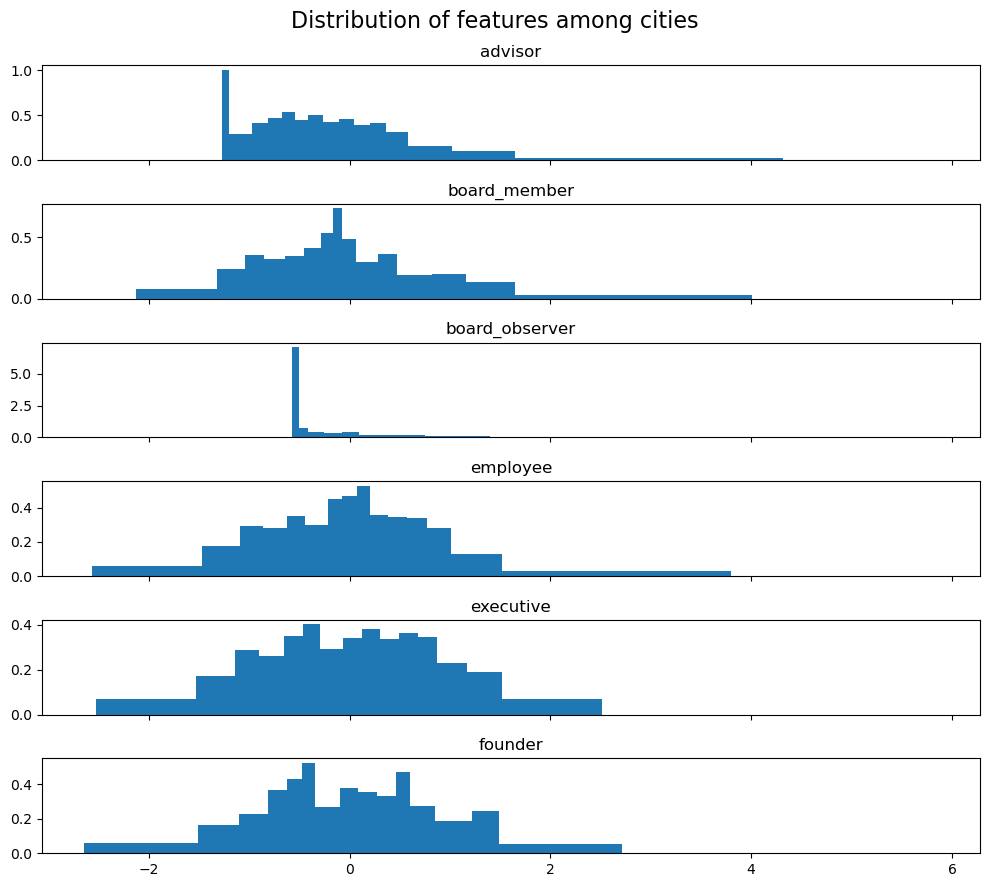

In [13]:
features = df_stats_cities[cols_fingerprint]

preprocess = Pipeline([
    ('scaler', StandardScaler()), # Scaling the data so that all the features become comparable
    #('normalizer', Normalizer()) # Normalizing the data so that each sample has unit norm
])

#features_processed = features.copy()
features_processed = pd.DataFrame(preprocess.fit_transform(features), columns = features.columns)

#fig, axs = subplots(nrows = features_processed.shape[1], ncols = 1, figsize = (10, 10), sharex = True, tight_layout = True)
fig, axs = subplots(nrows = features_processed.shape[1], ncols = 1, figsize = (10, 1.5 * features_processed.shape[1]), sharex = True, tight_layout = True)
for i in range(features_processed.shape[1]):
    ax = axs[i]
    n_bins = math.floor(3/4 * pow(features_processed.iloc[:, i].shape[0], 1/2))
    bins = features_processed.iloc[:, i].quantile(np.linspace(0, 1, n_bins + 1))
    ax.hist(features_processed.iloc[:, i], bins = bins, density = True)
    ax.set_title(features_processed.columns[i])
fig.suptitle('Distribution of features among cities', size = 16)
savefig(path_images + 'preprocessed features.png', bbox_inches = 'tight')
show()

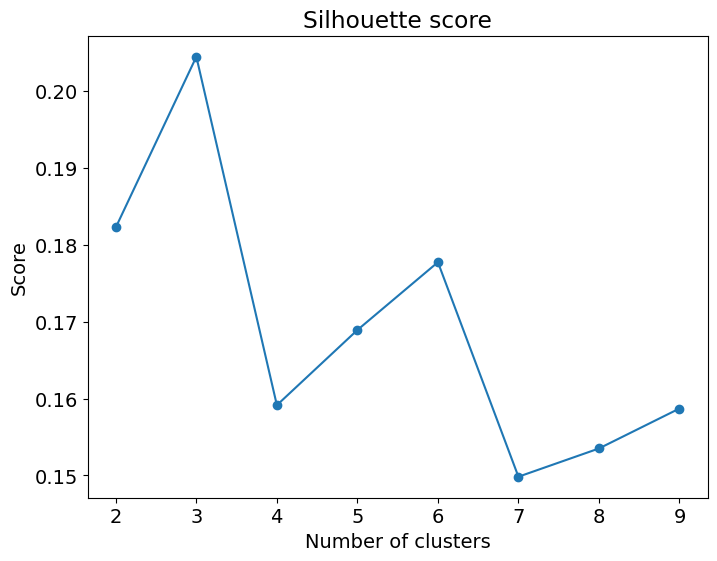

In [18]:
metric = 'euclidean'; linkage = 'ward'
#metric = 'euclidean'; linkage = 'average'
#metric = 'cosine'; linkage = 'average'

list_k = []
list_scores = []

for k in range(2, 10):
    labels = AgglomerativeClustering(n_clusters = k, metric = metric, linkage = linkage).fit_predict(features_processed)
    list_k.append(k)
    list_scores.append(silhouette_score(X = features_processed, labels = labels, metric = metric))

###

rcParams['font.size'] = 14

fig, ax = subplots(figsize = (8, 6))
ax.plot(list_k, list_scores)
ax.scatter(list_k, list_scores)
#ax.set_xlim(0, 10)
#ax.set_ylim(-1, 1)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Score')
ax.set_title('Silhouette score')
savefig(path_images + 'score.png', bbox_inches = 'tight')
show()

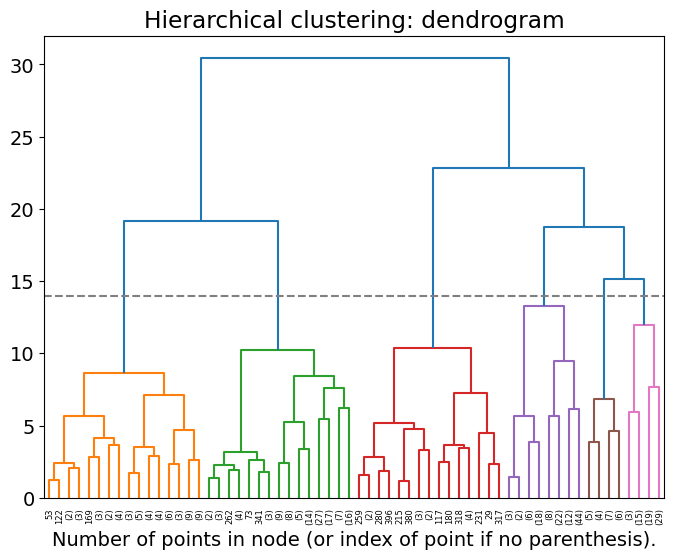

In [27]:
#n_clusters = 3; threshold_separation = 20
n_clusters = 6; threshold_separation = 14

model = AgglomerativeClustering(n_clusters = n_clusters, metric = metric, linkage = linkage, compute_distances = True)
model = model.fit(features_processed)

fig, ax = subplots(figsize = (8, 6))
plot_dendrogram(model, p = 5, truncate_mode = 'level', color_threshold = threshold_separation)
ax.axhline(y = threshold_separation, color = 'grey', linestyle = '--')
ax.set_xlabel('Number of points in node (or index of point if no parenthesis).')
ax.set_title('Hierarchical clustering: dendrogram')
savefig(path_images + 'dendrogram.png', bbox_inches = 'tight')
show()

In [28]:
#values = 1   # per contare il numero di città in USA/Europe
values = df_stats_cities['companies']   # per contare il numero di compagnie in USA/Europe

stats_clusters = df_stats_cities.assign(
    Europe = values * (df_stats_cities['area'] == 'Europe'),
    USA = values * (df_stats_cities['area'] == 'USA')
).assign(cluster = model.labels_, cities = 1).groupby('cluster')[['cities', 'companies'] + cols_area + cols_fingerprint].sum()

for cols in [cols_area, cols_fingerprint]:
    stats_clusters[cols] = stats_clusters[cols].div(stats_clusters[cols].sum(axis = 1), axis = 0)

stats_clusters.sort_values(by = cols_area[0], axis = 0, ascending = False, inplace = True)   # sort by fraction of first area
stats_clusters.index = pd.Index(list(range(n_clusters)), name = 'cluster')   # reset index

stats_clusters

,cities,companies,Europe,USA,advisor,board_member,board_observer,employee,executive,founder
cluster,,,,,,,,,,
0,115,92655,0.436879,0.563121,0.012238,0.032338,0.000685,0.141142,0.357992,0.455605
1,60,17479,0.289319,0.710681,0.008924,0.049555,0.000621,0.172219,0.422045,0.346636
2,66,31787,0.186649,0.813351,0.017388,0.053375,0.001171,0.129128,0.397031,0.401907
3,22,4786,0.101755,0.898245,0.012324,0.052584,0.008127,0.130565,0.413182,0.383219
4,22,22546,0.055265,0.944735,0.039502,0.058512,0.001977,0.133654,0.321181,0.445174
5,118,33225,0.028081,0.971919,0.006855,0.031075,0.000597,0.125645,0.485720,0.350109


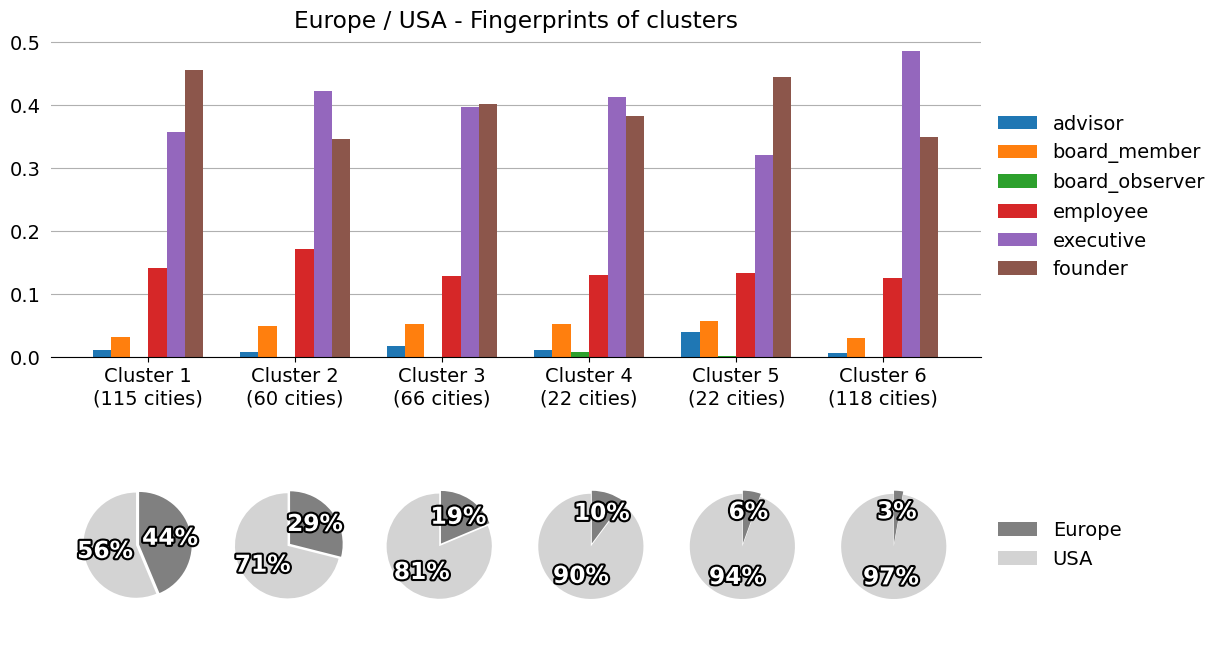

In [29]:
fig = figure(figsize = (12, 8))
gs = GridSpec(
    nrows = 2, ncols = n_clusters + 2, figure = fig,
    hspace = 0.3, height_ratios = [3, 2],
    width_ratios = [0.01] + [1] * n_clusters + [0.01]   # 2 extra columns to align pie charts with bar charts
)

ax_bar = fig.add_subplot(gs[0, :])
axs_pie = []
for i in range(n_clusters + 2):
    axs_pie.append(fig.add_subplot(gs[1, i]))

###

x_base = np.arange(n_clusters)
n_features = len(cols_fingerprint)
width = 0.75 / n_features
x_labels = x_base + width * (n_features - 1) / 2

labels = [
    'Cluster ' + str(i + 1)
    + '\n(' + str(stats_clusters.loc[i, 'cities']) + ' cities)'
#    + '\n(' + str(stats_clusters.loc[i, 'companies']) + ' companies)'
    for i in range(n_clusters)
]

for i in range(n_features):
    ax_bar.bar(x_base + i * width, stats_clusters[cols_fingerprint[i]], width = width, label = cols_fingerprint[i], zorder = 2)

ax_bar.spines[['left', 'right', 'top']].set_visible(False)
ax_bar.grid(axis = 'y')
for tick in ax_bar.yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    tick.tick2line.set_visible(False)
ax_bar.set_xticks(x_labels, labels)
ax_bar.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), frameon = False)
ax_bar.set_title(' / '.join(cols_area) + ' - Fingerprints of clusters')

###

for i in [0, -1]:
    axs_pie[i].axis('off')

for i in range(n_clusters):
    ax = axs_pie[i + 1]
    wedges, texts, autotexts = ax.pie(
        stats_clusters.loc[i, cols_area].values,
        explode = [0.03] * len(cols_area),
        colors = ['grey', 'lightgrey'],
        startangle = 90,
        counterclock = False,
        autopct = lambda x: f'{x:.0f}%',
        textprops = dict(
            color = 'white', size = 'large', weight = 'bold',
            path_effects = [withStroke(linewidth = 3, foreground = 'black')]
        )
    )
    #ax.set_title('Cluster ' + str(i + 1))
axs_pie[-1].legend(wedges, cols_area, loc = 'center left', bbox_to_anchor = (1, 0.5), frameon = False)

###

savefig(path_images + 'fingerprints-clusters.png', bbox_inches = 'tight')
show()

# Analisi: profilo in base ai settori di mercato

In [30]:
%%time

df_organizations_sel = df_organizations.loc[
    (~df_organizations['category_groups_list'].isna())
    & (df_organizations['founded_on'] < '2016-01-01')
]
print(f'Companies that satisfy the criteria: {df_organizations_sel.shape[0]} of {df_organizations.shape[0]}\n')

df_dummy = df_organizations_sel['category_groups_list'].str.get_dummies(sep = ',')
sectors_numbers = df_dummy.sum(axis = 0).sort_values(ascending = False)
#print(sectors_numbers)
cols_fingerprint = sectors_numbers.index[:10].sort_values().tolist()

df_stats_companies = pd.concat(
    (df_organizations_sel[['name', 'area', 'country_code', 'city']], df_dummy[cols_fingerprint]),
    axis = 1
)

df_stats_companies['country_code'] = df_stats_companies['country_code'].apply(lambda x: x if type(x) == str else None)
df_stats_companies['city'] = df_stats_companies['city'].apply(lambda x: unidecode(x) if type(x) == str else None)

df_stats_companies

Companies that satisfy the criteria: 1963854 of 3090736

CPU times: user 15.6 s, sys: 1.9 s, total: 17.5 s
Wall time: 18 s


,name,area,country_code,city,Commerce and Shopping,Financial Services,Information Technology,Manufacturing,Media and Entertainment,Other,Professional Services,Real Estate,Sales and Marketing,Software
0,Wetpaint,USA,USA,New York,0,0,0,0,1,0,0,0,1,0
1,Zoho,USA,USA,Pleasanton,0,0,1,0,0,1,0,0,0,1
2,Digg,USA,USA,New York,0,0,0,0,1,0,0,0,0,0
3,Omidyar Network,USA,USA,Redwood City,0,1,0,0,0,0,0,0,0,1
4,Meta,USA,USA,Menlo Park,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3090645,Tecnaura,None,ARE,Dubai,1,0,1,0,0,0,0,0,1,0
3090679,Lostisland,Europe,AUT,Rastenfeld,0,0,0,0,0,0,0,0,0,0
3090689,123 Design,USA,USA,Sarasota,0,0,0,1,0,0,0,1,0,1
3090700,infoguysid,None,None,None,0,0,0,0,1,0,0,0,0,0


In [31]:
print(f'N. of companies:', df_stats_companies.shape[0])
print(f'In USA:', df_stats_companies[df_stats_companies['area'] == 'USA'].shape[0])
print(f'In Europe:', df_stats_companies[df_stats_companies['area'] == 'Europe'].shape[0])
print(f'In Italy:', df_stats_companies[df_stats_companies['country_code'] == 'ITA'].shape[0])
print(f'In Milan:', df_stats_companies[(df_stats_companies['country_code'] == 'ITA') & (df_stats_companies['city'].isin(['Milano', 'Milan']))].shape[0])
print(f'In Rome:', df_stats_companies[(df_stats_companies['country_code'] == 'ITA') & (df_stats_companies['city'].isin(['Roma', 'Rome']))].shape[0])
print(f'In Catania:', df_stats_companies[(df_stats_companies['country_code'] == 'ITA') & (df_stats_companies['city'].isin(['Catania']))].shape[0])

N. of companies: 1963854
In USA: 861996
In Europe: 622722
In Italy: 56301
In Milan: 6035
In Rome: 3468
In Catania: 241


## Stats of cites

In [32]:
n_min_of_companies = 100

df_stats_companies[cols_fingerprint] = df_stats_companies[cols_fingerprint].div(
    df_stats_companies[cols_fingerprint].sum(axis = 1), axis = 0) # fraction of roles instead of number of workers

df_stats_cities = (
    df_stats_companies
    .groupby(['city', 'country_code', 'area'])
    .agg({'name': 'count'} | {c: 'mean' for c in cols_fingerprint})
    .rename(columns = {'name': 'companies'})
)

df_stats_cities = df_stats_cities[df_stats_cities['companies'] > n_min_of_companies].reset_index()
df_stats_cities

,city,country_code,area,companies,Commerce and Shopping,Financial Services,Information Technology,Manufacturing,Media and Entertainment,Other,Professional Services,Real Estate,Sales and Marketing,Software
0,'s-gravenhage,NLD,Europe,140,0.158269,0.020672,0.111757,0.024548,0.134367,0.035530,0.084625,0.031008,0.303618,0.095607
1,'s-hertogenbosch,NLD,Europe,404,0.147310,0.053074,0.115850,0.054755,0.109990,0.060855,0.110231,0.035543,0.164361,0.148031
2,A Coruna,ESP,Europe,356,0.127023,0.025890,0.084951,0.154261,0.101133,0.071197,0.120550,0.070119,0.141855,0.103020
3,Aachen,DEU,Europe,426,0.078647,0.022546,0.115031,0.177498,0.075243,0.103758,0.111804,0.051149,0.080327,0.183996
4,Aalborg,DNK,Europe,286,0.090027,0.028782,0.127845,0.139558,0.073628,0.082329,0.114458,0.045850,0.073963,0.223561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2104,Zlin,CZE,Europe,106,0.135000,0.047500,0.095833,0.225000,0.070000,0.041667,0.070833,0.033333,0.131667,0.149167
2105,Zoetermeer,NLD,Europe,261,0.195051,0.030568,0.173581,0.064047,0.083697,0.082606,0.070233,0.042213,0.109170,0.148836
2106,Zug,CHE,Europe,654,0.054260,0.159096,0.123690,0.065918,0.076713,0.090242,0.195222,0.052447,0.052159,0.130253
2107,Zurich,CHE,Europe,3699,0.065093,0.117241,0.112321,0.055509,0.110508,0.090041,0.143817,0.066422,0.096269,0.142778


In [34]:
df_stats_cities.groupby('area').agg({'city': 'count', 'companies': 'sum'}).rename(columns = {'city': 'cities'})

,cities,companies
area,,
Europe,787,372717
USA,1322,716615


### Clustering

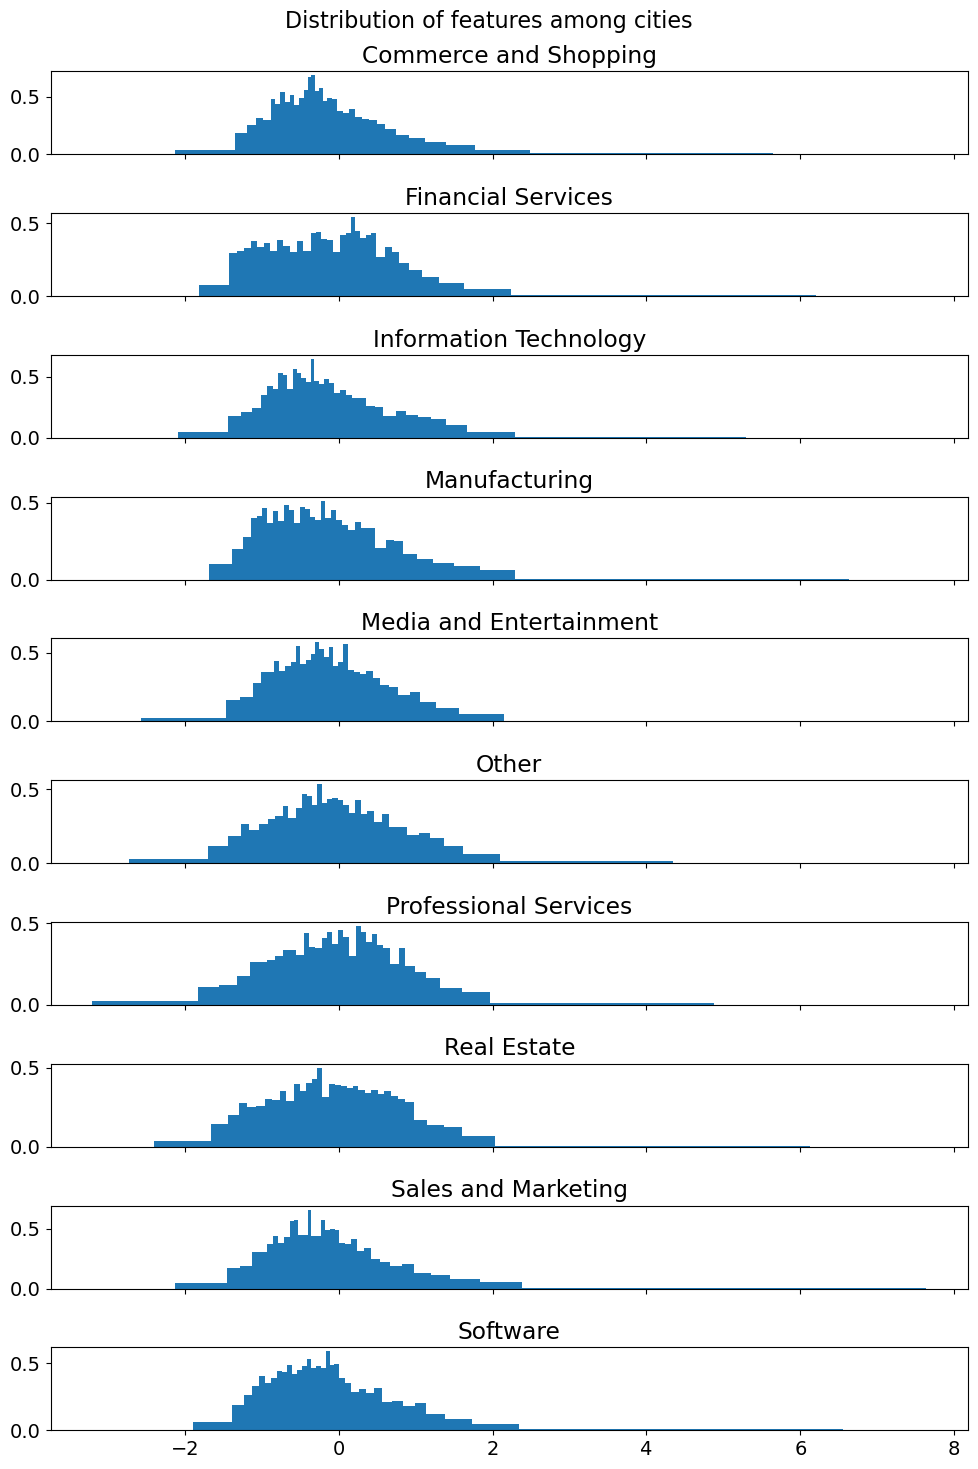

In [35]:
features = df_stats_cities[cols_fingerprint]

preprocess = Pipeline([
    ('scaler', StandardScaler()), # Scaling the data so that all the features become comparable
    #('normalizer', Normalizer()) # Normalizing the data so that each sample has unit norm
])

#features_processed = features.copy()
features_processed = pd.DataFrame(preprocess.fit_transform(features), columns = features.columns)

fig, axs = subplots(nrows = features_processed.shape[1], ncols = 1, figsize = (10, 1.5 * features_processed.shape[1]), sharex = True, tight_layout = True)
for i in range(features_processed.shape[1]):
    ax = axs[i]
    n_bins = math.floor(3/4 * pow(features_processed.iloc[:, i].shape[0], 1/2))
    bins = features_processed.iloc[:, i].quantile(np.linspace(0, 1, n_bins + 1))
    ax.hist(features_processed.iloc[:, i], bins = bins, density = True)
    ax.set_title(features_processed.columns[i])
fig.suptitle('Distribution of features among cities', size = 16)
savefig(path_images + 'preprocessed features.png', bbox_inches = 'tight')
show()

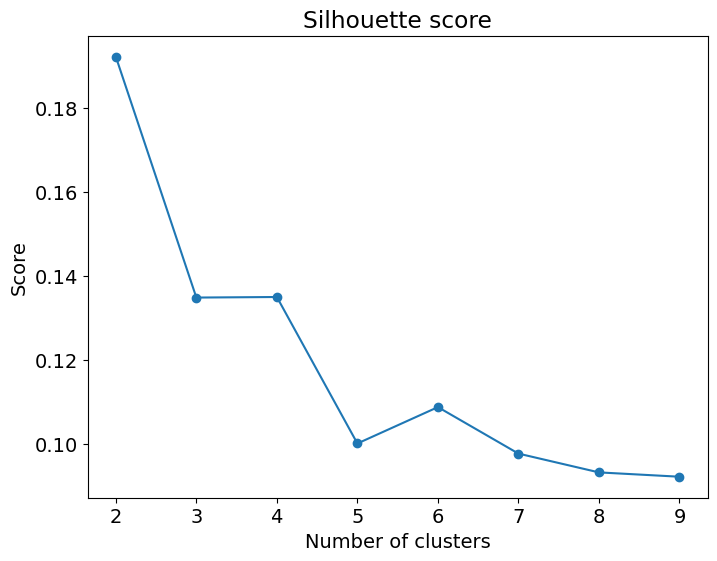

In [36]:
metric = 'euclidean'; linkage = 'ward'
#metric = 'euclidean'; linkage = 'average'
#metric = 'cosine'; linkage = 'average'

list_k = []
list_scores = []

for k in range(2, 10):
    labels = AgglomerativeClustering(n_clusters = k, metric = metric, linkage = linkage).fit_predict(features_processed)
    list_k.append(k)
    list_scores.append(silhouette_score(X = features_processed, labels = labels, metric = metric))

###

rcParams['font.size'] = 14

fig, ax = subplots(figsize = (8, 6))
ax.plot(list_k, list_scores)
ax.scatter(list_k, list_scores)
#ax.set_xlim(0, 10)
#ax.set_ylim(-1, 1)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Score')
ax.set_title('Silhouette score')
savefig(path_images + 'score.png', bbox_inches = 'tight')
show()

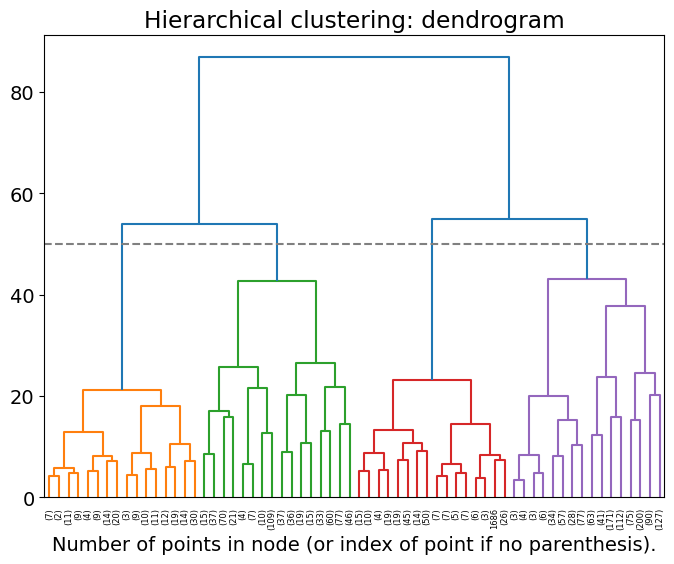

In [37]:
n_clusters = 4

model = AgglomerativeClustering(n_clusters = n_clusters, metric = metric, linkage = linkage, compute_distances = True)
model = model.fit(features_processed)

threshold_separation = 50

fig, ax = subplots(figsize = (8, 6))
plot_dendrogram(model, p = 5, truncate_mode = 'level', color_threshold = threshold_separation)
ax.axhline(y = threshold_separation, color = 'grey', linestyle = '--')
ax.set_xlabel('Number of points in node (or index of point if no parenthesis).')
ax.set_title('Hierarchical clustering: dendrogram')
savefig(path_images + 'dendrogram.png', bbox_inches = 'tight')
show()

In [38]:
#values = 1   # per contare il numero di città in USA/Europe
values = df_stats_cities['companies']   # per contare il numero di compagnie in USA/Europe

stats_clusters = df_stats_cities.assign(
    Europe = values * (df_stats_cities['area'] == 'Europe'),
    USA = values * (df_stats_cities['area'] == 'USA')
).assign(cluster = model.labels_, cities = 1).groupby('cluster')[['cities', 'companies'] + cols_area + cols_fingerprint].sum()

for cols in [cols_area, cols_fingerprint]:
    stats_clusters[cols] = stats_clusters[cols].div(stats_clusters[cols].sum(axis = 1), axis = 0)

stats_clusters.sort_values(by = cols_area[0], axis = 0, ascending = False, inplace = True)   # sort by fraction of first area
stats_clusters.index = pd.Index(list(range(n_clusters)), name = 'cluster')   # reset index

stats_clusters

,cities,companies,Europe,USA,Commerce and Shopping,Financial Services,Information Technology,Manufacturing,Media and Entertainment,Other,Professional Services,Real Estate,Sales and Marketing,Software
cluster,,,,,,,,,,,,,,
0,184,76957,0.994322,0.005678,0.164360,0.037421,0.096107,0.144444,0.086833,0.070762,0.094879,0.055046,0.120872,0.129275
1,596,500226,0.449397,0.550603,0.072331,0.075552,0.113574,0.095727,0.096220,0.104434,0.131815,0.075633,0.083174,0.151541
2,238,49413,0.231295,0.768705,0.105307,0.061943,0.050861,0.311282,0.060730,0.107713,0.089840,0.098162,0.055135,0.059027
3,1091,462736,0.129594,0.870406,0.085619,0.105594,0.065505,0.140899,0.076956,0.134234,0.124941,0.116046,0.069646,0.080560


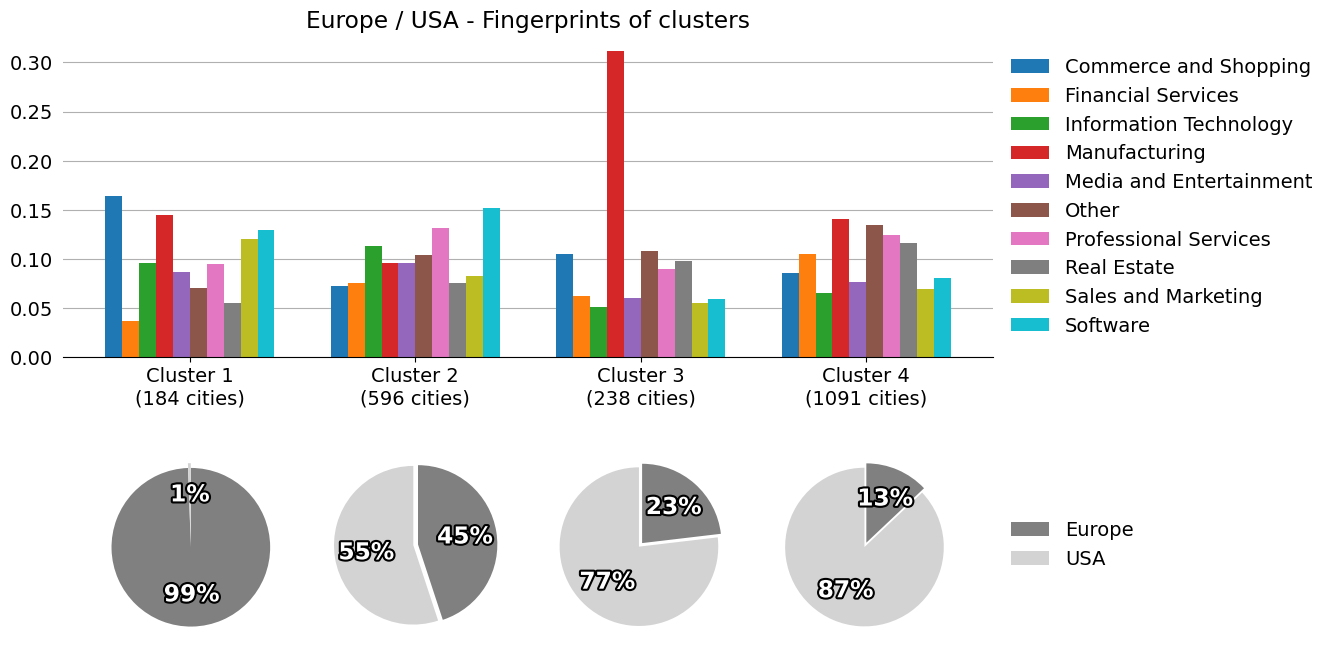

In [39]:
fig = figure(figsize = (12, 8))
gs = GridSpec(
    nrows = 2, ncols = n_clusters + 2, figure = fig,
    hspace = 0.3, height_ratios = [3, 2],
    width_ratios = [0.01] + [1] * n_clusters + [0.01]   # 2 extra columns to align pie charts with bar charts
)

ax_bar = fig.add_subplot(gs[0, :])
axs_pie = []
for i in range(n_clusters + 2):
    axs_pie.append(fig.add_subplot(gs[1, i]))

###

x_base = np.arange(n_clusters)
n_features = len(cols_fingerprint)
width = 0.75 / n_features
x_labels = x_base + width * (n_features - 1) / 2

labels = [
    'Cluster ' + str(i + 1)
    + '\n(' + str(stats_clusters.loc[i, 'cities']) + ' cities)'
#    + '\n(' + str(stats_clusters.loc[i, 'companies']) + ' companies)'
    for i in range(n_clusters)
]

for i in range(n_features):
    ax_bar.bar(x_base + i * width, stats_clusters[cols_fingerprint[i]], width = width, label = cols_fingerprint[i], zorder = 2)

ax_bar.spines[['left', 'right', 'top']].set_visible(False)
ax_bar.grid(axis = 'y')
for tick in ax_bar.yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    tick.tick2line.set_visible(False)
ax_bar.set_xticks(x_labels, labels)
ax_bar.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), frameon = False)
ax_bar.set_title(' / '.join(cols_area) + ' - Fingerprints of clusters')

###

for i in [0, -1]:
    axs_pie[i].axis('off')

for i in range(n_clusters):
    ax = axs_pie[i + 1]
    wedges, texts, autotexts = ax.pie(
        stats_clusters.loc[i, cols_area].values,
        explode = [0.03] * len(cols_area),
        colors = ['grey', 'lightgrey'],
        startangle = 90,
        counterclock = False,
        autopct = lambda x: f'{x:.0f}%',
        textprops = dict(
            color = 'white', size = 'large', weight = 'bold',
            path_effects = [withStroke(linewidth = 3, foreground = 'black')]
        )
    )
    #ax.set_title('Cluster ' + str(i + 1))
axs_pie[-1].legend(wedges, cols_area, loc = 'center left', bbox_to_anchor = (1, 0.5), frameon = False)

###

savefig(path_images + 'fingerprints-clusters.png', bbox_inches = 'tight')
show()